In [1]:
!pip install mxnet=="1.4.1"

    100% |████████████████████████████████| 28.4MB 1.9MB/s eta 0:00:011  17% |█████▊                          | 5.1MB 82.1MB/s eta 0:00:01
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

    100% |████████████████████████████████| 327kB 48.0MB/s ta 0:00:01
    100% |████████████████████████████████| 7.1MB 7.4MB/s  eta 0:00:01
    100% |████████████████████████████████| 81kB 50.3MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 36.7MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd163c7f57f3844689e3a78bae1f403648a6afb1d0866d87fbb/python_dateutil-2.8.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 194kB 55.7MB/s ta 0:00:01
    100% |████████████████████████████████| 10.4MB 5.0MB/s eta 0:00:011   26% |████████▍                       | 2.7MB 97.1MB/s eta 0:00:01
  Running setup.py bdist_wheel for holidays ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/40/a9/2b/94ac5464363d37564a87dc93a9d21a5850aac14a4608197003
  Running setup.py bdist_wheel for ujson ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
Successfull

In [3]:
# !pip install gluonts=="0.4.1"

In [4]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.2
1.4.1


In [5]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar
# from utils_gluonts11_deepstate import deep_state


INFO:root:Using CPU


In [6]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_id', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'm4_weekly_domain', 'm4_weekly_id', 'my_wee

#### Note

In SageMaker data are saved into the following folders (example shows m4_weekly):

```
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/test/data.json
```

In [34]:
dataname = "m4_quarterly_demographic"
dataset = get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_demographic.


In [35]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

# check length
print("length train dataset:", len(dataset.train))
print("length test dataset:", len(dataset.test))

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train dataset: 1858
length test dataset: 1858


In [36]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='3M'),
 'target': array([5351., 5386., 5443., 5350., 5532., 5646., 5712., 5638., 5811.,
        5949., 6009., 6021., 6021., 6089., 6199., 6335., 6333., 6427.,
        6494., 6503., 6654., 6769., 6946., 7096., 7165., 7330., 7382.,
        7474., 7474., 7677., 7812., 7744., 8023., 7974., 8148., 8121.,
        7937., 7926., 7850., 7917., 7884., 8206., 8313., 8266., 8098.,
        8469., 8745., 8670., 8870., 8757., 9034., 9376., 9177., 9229.,
        9484., 9562., 9580., 9795., 9784.], dtype=float32),
 'feat_static_cat': array([1], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_demographic/train/m4_quarterly_demographic_train.json'), line=1), row=1)}

## Plot Series

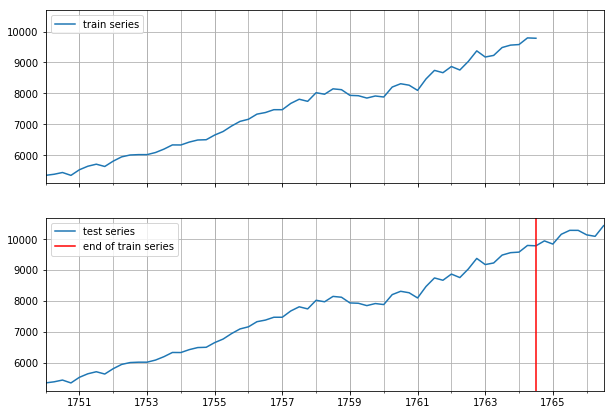

In [37]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [38]:
print("start:", dict(train_entry)["start"])
print("target:", dict(train_entry)["target"][:7])
print("feat_static_cat:", dict(train_entry)["feat_static_cat"])
print("length:", len(dataset.train))

start: 1750-01-31 00:00:00
target: [5351. 5386. 5443. 5350. 5532. 5646. 5712.]
feat_static_cat: [1]
length: 1858


In [39]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepstate import DeepStateEstimator

In [40]:
#########################
### deepstate wrapper ###

# data = "m4_yearly_other"
# seed = 44
# epochs = 500
# num_batches = 100
# batch_size = 32

def deepstate(dataname, seed=42, epochs=100, num_batches=50):
    
    mx.random.seed(seed)
    np.random.seed(seed)

    dataset = get_dataset(dataname, regenerate=False)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=num_batches,
        learning_rate=1e-3,
        )

    cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
    estimator = DeepStateEstimator(
        trainer=trainer,
        cardinality=[cardinality],
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True,
        )

    predictor=estimator.train(dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
            dataset.test, predictor=predictor, num_samples=100
        )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = num_batches    

    df = pd.DataFrame([output])
    return df

## Results

In [41]:
dataname

'm4_quarterly_demographic'

In [42]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df=deepstate(dataname, seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_demographic.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepStateTrainingNetwork: 122249
100%|██████████| 50/50 [00:01<00:00, 26.13it/s, avg_epoch_loss=0.347]
INFO:root:Epoch[0] Elapsed time 1.915 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.347353
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.33it/s, avg_epoch_loss=0.134]
INFO:root:Epoch[1] Elapsed time 1.831 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.134113
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.94it/s, avg_epoch_loss=0.0413]
INFO:root:Epoch[2] Elapsed time 1.791 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.041307
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.58it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[3] Elapsed time 1.815 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.139514
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 26.74it/s, avg_epoch_loss=-

100%|██████████| 50/50 [00:01<00:00, 27.86it/s, avg_epoch_loss=-1.72]
INFO:root:Epoch[37] Elapsed time 1.796 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.724304
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 25.48it/s, avg_epoch_loss=-1.72]
INFO:root:Epoch[38] Elapsed time 1.964 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-1.724018
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.65it/s, avg_epoch_loss=-1.75]
INFO:root:Epoch[39] Elapsed time 1.810 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.750924
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.90it/s, avg_epoch_loss=-1.76]
INFO:root:Epoch[40] Elapsed time 1.794 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-1.755250
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.78it/s, avg_epoch_loss=-1.63]
INFO:root:Epoch[41] Elapsed time 1.802 seconds

100%|██████████| 50/50 [00:01<00:00, 27.81it/s, avg_epoch_loss=-1.86]
INFO:root:Epoch[74] Elapsed time 1.800 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-1.861210
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.58it/s, avg_epoch_loss=-1.93]
INFO:root:Epoch[75] Elapsed time 1.814 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-1.933572
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 26.88it/s, avg_epoch_loss=-1.95]
INFO:root:Epoch[76] Elapsed time 1.862 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-1.953007
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.67it/s, avg_epoch_loss=-1.83]
INFO:root:Epoch[77] Elapsed time 1.809 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=-1.826164
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.89it/s, avg_epoch_loss=-1.8]
INFO:root:Epoch[78] Elapsed time 1.795 seconds


      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.58826  0.125119  36.460292            0.133558            0.102414    42   

   epochs  num_batches  
0     100           50  
Seed: 43


100%|██████████| 50/50 [00:01<00:00, 26.75it/s, avg_epoch_loss=0.391]
INFO:root:Epoch[0] Elapsed time 1.873 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.391072
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.59it/s, avg_epoch_loss=0.154]
INFO:root:Epoch[1] Elapsed time 1.814 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.153781
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.16it/s, avg_epoch_loss=0.0374]
INFO:root:Epoch[2] Elapsed time 1.842 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.037375
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.30it/s, avg_epoch_loss=-.206]
INFO:root:Epoch[3] Elapsed time 1.833 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.205531
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 28.05it/s, avg_epoch_loss=-.488]
INFO:root:Epoch[4] Elapsed time 1.785 seconds
INFO:root:Epoc

100%|██████████| 50/50 [00:01<00:00, 27.89it/s, avg_epoch_loss=-1.8]
INFO:root:Epoch[37] Elapsed time 1.797 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.801905
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.80it/s, avg_epoch_loss=-1.77]
INFO:root:Epoch[38] Elapsed time 1.801 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-1.766697
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.72it/s, avg_epoch_loss=-1.73]
INFO:root:Epoch[39] Elapsed time 1.805 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.733554
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 28.01it/s, avg_epoch_loss=-1.8]
INFO:root:Epoch[40] Elapsed time 1.787 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-1.801317
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.96it/s, avg_epoch_loss=-1.7]
INFO:root:Epoch[41] Elapsed time 1.790 seconds
IN

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 27.86it/s, avg_epoch_loss=-1.96]
INFO:root:Epoch[74] Elapsed time 1.796 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-1.958745
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 27.92it/s, avg_epoch_loss=-1.97]
INFO:root:Epoch[75] Elapsed time 1.793 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-1.966551
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 27.96it/s, avg_epoch_loss=-1.95]
INFO:root:Epoch[76] Elapsed time 1.790 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-1.950200
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 27.80it/s, avg_epoch_loss=-1.83]
INFO:root:Epoch[77] Elapsed time 1.801 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=-1.832501
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 27.58it/s, avg_epoch_loss=-1.8]

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.583805  0.127778  34.26984            0.141176            0.087032    43   

   epochs  num_batches  
0     100           50  
Seed: 44


100%|██████████| 50/50 [00:01<00:00, 26.62it/s, avg_epoch_loss=0.353]
INFO:root:Epoch[0] Elapsed time 1.880 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.353460
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 26.46it/s, avg_epoch_loss=0.137]
INFO:root:Epoch[1] Elapsed time 1.892 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.136916
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.44it/s, avg_epoch_loss=0.0381]
INFO:root:Epoch[2] Elapsed time 1.824 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.038141
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.85it/s, avg_epoch_loss=-.178]
INFO:root:Epoch[3] Elapsed time 1.797 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.178069
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.31it/s, avg_epoch_loss=-.472]
INFO:root:Epoch[4] Elapsed time 1.835 seconds
INFO:root:Epoc

100%|██████████| 50/50 [00:01<00:00, 27.84it/s, avg_epoch_loss=-1.82]
INFO:root:Epoch[37] Elapsed time 1.798 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.823789
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 26.93it/s, avg_epoch_loss=-1.84]
INFO:root:Epoch[38] Elapsed time 1.858 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-1.838288
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.60it/s, avg_epoch_loss=-1.79]
INFO:root:Epoch[39] Elapsed time 1.816 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.786446
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.83it/s, avg_epoch_loss=-1.81]
INFO:root:Epoch[40] Elapsed time 1.798 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-1.807777
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.78it/s, avg_epoch_loss=-1.71]
INFO:root:Epoch[41] Elapsed time 1.804 seconds

100%|██████████| 50/50 [00:01<00:00, 26.99it/s, avg_epoch_loss=-1.96]
INFO:root:Epoch[74] Elapsed time 1.854 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-1.957638
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.03it/s, avg_epoch_loss=-2.03]
INFO:root:Epoch[75] Elapsed time 1.851 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-2.030413
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.05it/s, avg_epoch_loss=-2.03]
INFO:root:Epoch[76] Elapsed time 1.852 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-2.033847
INFO:root:Loading parameters from best epoch (66)
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 27.24it/s, avg_epoch_loss=-1.89]
INFO:root:Epoch[77] Elapsed time 1.837 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=-1.885869
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 27.71it/s, avg_epoch_loss=-

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.630627  0.129554  38.837106            0.143469            0.114096   

   seed  epochs  num_batches  
0    44     100           50  
m4_quarterly_demographic


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.588260,0.125119,36.460292,0.133558,0.102414,42,100,50
0,1.583805,0.127778,34.269840,0.141176,0.087032,43,100,50
0,1.630627,0.129554,38.837106,0.143469,0.114096,44,100,50


In [43]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df=deepstate(dataname, seed=i, epochs=100, num_batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_demographic.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepStateTrainingNetwork: 122249


Seed: 42


100%|██████████| 100/100 [00:03<00:00, 26.51it/s, avg_epoch_loss=0.241]
INFO:root:Epoch[0] Elapsed time 3.774 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.240733
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.58it/s, avg_epoch_loss=-.0491]
INFO:root:Epoch[1] Elapsed time 3.629 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.049104
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.49it/s, avg_epoch_loss=-.582]
INFO:root:Epoch[2] Elapsed time 3.639 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.582179
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.45it/s, avg_epoch_loss=-.948]
INFO:root:Epoch[3] Elapsed time 3.645 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.947886
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.90it/s, avg_epoch_loss=-1.18]
INFO:root:Epoch[4] Elapsed time 3.585 seconds
IN

100%|██████████| 100/100 [00:03<00:00, 27.26it/s, avg_epoch_loss=-1.9]
INFO:root:Epoch[37] Elapsed time 3.670 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.897391
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 25.21it/s, avg_epoch_loss=-1.89]
INFO:root:Epoch[38] Elapsed time 3.968 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-1.889585
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 25.82it/s, avg_epoch_loss=-1.83]
INFO:root:Epoch[39] Elapsed time 3.875 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.827244
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.89it/s, avg_epoch_loss=-2]
INFO:root:Epoch[40] Elapsed time 3.587 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-1.998488
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.07it/s, avg_epoch_loss=-1.97]
INFO:root:Epoch[41] Elapsed time 3.696 s

INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.71it/s, avg_epoch_loss=-2.19]
INFO:root:Epoch[74] Elapsed time 3.611 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-2.188853
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.50it/s, avg_epoch_loss=-2.14]
INFO:root:Epoch[75] Elapsed time 3.641 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-2.143026
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.48it/s, avg_epoch_loss=-2.32]
INFO:root:Epoch[76] Elapsed time 3.641 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-2.315632
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.51it/s, avg_epoch_loss=-2.29]
INFO:root:Epoch[77] Elapsed time 3.637 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=-2.285015
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.81it/s, avg_epoch_loss=

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.65275  0.129002  40.962738            0.139172            0.112518    42   

   epochs  num_batches  
0     100          100  
Seed: 43


100%|██████████| 100/100 [00:03<00:00, 27.02it/s, avg_epoch_loss=0.272]
INFO:root:Epoch[0] Elapsed time 3.703 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.272427
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.81it/s, avg_epoch_loss=-.0841]
INFO:root:Epoch[1] Elapsed time 3.597 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.084078
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.74it/s, avg_epoch_loss=-.57]
INFO:root:Epoch[2] Elapsed time 3.607 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.570293
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.71it/s, avg_epoch_loss=-.917]
INFO:root:Epoch[3] Elapsed time 3.610 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.916614
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.66it/s, avg_epoch_loss=-1.2]
INFO:root:Epoch[4] Elapsed time 3.617 seconds
INFO

100%|██████████| 100/100 [00:03<00:00, 27.01it/s, avg_epoch_loss=-1.95]
INFO:root:Epoch[37] Elapsed time 3.704 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.946975
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.90it/s, avg_epoch_loss=-1.91]
INFO:root:Epoch[38] Elapsed time 3.586 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-1.905608
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.98it/s, avg_epoch_loss=-1.85]
INFO:root:Epoch[39] Elapsed time 3.709 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.852038
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.59it/s, avg_epoch_loss=-1.98]
INFO:root:Epoch[40] Elapsed time 3.626 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-1.981357
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.95it/s, avg_epoch_loss=-2]
INFO:root:Epoch[41] Elapsed time 3.580 

INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.75it/s, avg_epoch_loss=-2.14]
INFO:root:Epoch[74] Elapsed time 3.740 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-2.144705
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.60it/s, avg_epoch_loss=-2.15]
INFO:root:Epoch[75] Elapsed time 3.626 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-2.152717
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.59it/s, avg_epoch_loss=-2.32]
INFO:root:Epoch[76] Elapsed time 3.628 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-2.316859
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.48it/s, avg_epoch_loss=-2.27]
INFO:root:Epoch[77] Elapsed time 3.640 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=-2.267218
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.69it/s, avg_epoch_loss=

       MASE    sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.497503  0.12314  36.93329            0.135078            0.098882    43   

   epochs  num_batches  
0     100          100  
Seed: 44


INFO:root:Number of parameters in DeepStateTrainingNetwork: 122249
100%|██████████| 100/100 [00:03<00:00, 26.91it/s, avg_epoch_loss=0.245]
INFO:root:Epoch[0] Elapsed time 3.718 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.245188
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.91it/s, avg_epoch_loss=-.07]
INFO:root:Epoch[1] Elapsed time 3.586 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.069964
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.76it/s, avg_epoch_loss=-.548]
INFO:root:Epoch[2] Elapsed time 3.604 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.547700
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.93it/s, avg_epoch_loss=-.885]
INFO:root:Epoch[3] Elapsed time 3.582 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.884973
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.88it/s, avg_e

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.92it/s, avg_epoch_loss=-1.99]
INFO:root:Epoch[37] Elapsed time 3.583 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.994026
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 28.02it/s, avg_epoch_loss=-1.97]
INFO:root:Epoch[38] Elapsed time 3.571 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-1.965944
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 28.00it/s, avg_epoch_loss=-1.88]
INFO:root:Epoch[39] Elapsed time 3.576 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.883821
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.86it/s, avg_epoch_loss=-2.05]
INFO:root:Epoch[40] Elapsed time 3.593 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-2.046878
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.79it/s, avg_epoch_loss=

INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.86it/s, avg_epoch_loss=-2.21]
INFO:root:Epoch[74] Elapsed time 3.591 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-2.205478
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.89it/s, avg_epoch_loss=-2.15]
INFO:root:Epoch[75] Elapsed time 3.587 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-2.148928
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.65it/s, avg_epoch_loss=-2.3]
INFO:root:Epoch[76] Elapsed time 3.618 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-2.295896
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.76it/s, avg_epoch_loss=-2.32]
INFO:root:Epoch[77] Elapsed time 3.605 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=-2.319704
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 27.67it/s, avg_epoch_loss=-

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.553545  0.121975  40.237242            0.127915            0.102701   

   seed  epochs  num_batches  
0    44     100          100  
m4_quarterly_demographic


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.652750,0.129002,40.962738,0.139172,0.112518,42,100,100
0,1.497503,0.123140,36.933290,0.135078,0.098882,43,100,100
0,1.553545,0.121975,40.237242,0.127915,0.102701,44,100,100


In [45]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df=deepstate(dataname, seed=i, epochs=117, num_batches=50)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_demographic.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepStateTrainingNetwork: 122249


Seed: 42


100%|██████████| 50/50 [00:01<00:00, 26.77it/s, avg_epoch_loss=0.347]
INFO:root:Epoch[0] Elapsed time 1.871 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.347353
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.60it/s, avg_epoch_loss=0.134]
INFO:root:Epoch[1] Elapsed time 1.813 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.134113
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.97it/s, avg_epoch_loss=0.0413]
INFO:root:Epoch[2] Elapsed time 1.789 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.041307
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 28.31it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[3] Elapsed time 1.768 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.139514
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 28.05it/s, avg_epoch_loss=-.477]
INFO:root:Epoch[4] Elapsed time 1.784 seconds
INFO:root:Epoch

100%|██████████| 50/50 [00:01<00:00, 27.91it/s, avg_epoch_loss=-1.72]
INFO:root:Epoch[37] Elapsed time 1.793 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.724304
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.76it/s, avg_epoch_loss=-1.72]
INFO:root:Epoch[38] Elapsed time 1.803 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-1.724018
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.64it/s, avg_epoch_loss=-1.75]
INFO:root:Epoch[39] Elapsed time 1.813 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.750924
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.70it/s, avg_epoch_loss=-1.76]
INFO:root:Epoch[40] Elapsed time 1.807 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-1.755250
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 26.47it/s, avg_epoch_loss=-1.63]
INFO:root:Epoch[41] Elapsed time 1.891 seconds

100%|██████████| 50/50 [00:01<00:00, 27.34it/s, avg_epoch_loss=-1.86]
INFO:root:Epoch[74] Elapsed time 1.830 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-1.861210
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.83it/s, avg_epoch_loss=-1.93]
INFO:root:Epoch[75] Elapsed time 1.798 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-1.933572
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.22it/s, avg_epoch_loss=-1.95]
INFO:root:Epoch[76] Elapsed time 1.839 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-1.953007
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.88it/s, avg_epoch_loss=-1.83]
INFO:root:Epoch[77] Elapsed time 1.796 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=-1.826164
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.76it/s, avg_epoch_loss=-1.8]
INFO:root:Epoch[78] Elapsed time 1.805 seconds


100%|██████████| 50/50 [00:01<00:00, 27.64it/s, avg_epoch_loss=-2.12]
INFO:root:Epoch[111] Elapsed time 1.811 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-2.124527
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.68it/s, avg_epoch_loss=-2.11]
INFO:root:Epoch[112] Elapsed time 1.808 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-2.108326
INFO:root:Loading parameters from best epoch (102)
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 27.72it/s, avg_epoch_loss=-1.97]
INFO:root:Epoch[113] Elapsed time 1.805 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=-1.970721
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 27.56it/s, avg_epoch_loss=-1.98]
INFO:root:Epoch[114] Elapsed time 1.816 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=-1.980953
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 27.82it/s, av

      MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.61193  0.126111  40.20527            0.134461            0.104178    42   

   epochs  num_batches  
0     117           50  
Seed: 43


INFO:root:Number of parameters in DeepStateTrainingNetwork: 122249
100%|██████████| 50/50 [00:01<00:00, 26.03it/s, avg_epoch_loss=0.391]
INFO:root:Epoch[0] Elapsed time 1.923 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.391072
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.12it/s, avg_epoch_loss=0.154]
INFO:root:Epoch[1] Elapsed time 1.845 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.153781
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.66it/s, avg_epoch_loss=0.0374]
INFO:root:Epoch[2] Elapsed time 1.809 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.037375
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.76it/s, avg_epoch_loss=-.206]
INFO:root:Epoch[3] Elapsed time 1.803 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.205531
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.72it/s, avg_epoch_loss=

100%|██████████| 50/50 [00:01<00:00, 27.37it/s, avg_epoch_loss=-1.8]
INFO:root:Epoch[37] Elapsed time 1.831 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.801905
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.75it/s, avg_epoch_loss=-1.77]
INFO:root:Epoch[38] Elapsed time 1.804 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-1.766697
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.29it/s, avg_epoch_loss=-1.73]
INFO:root:Epoch[39] Elapsed time 1.835 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.733554
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.53it/s, avg_epoch_loss=-1.8]
INFO:root:Epoch[40] Elapsed time 1.818 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-1.801317
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.04it/s, avg_epoch_loss=-1.7]
INFO:root:Epoch[41] Elapsed time 1.851 seconds
IN

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 26.92it/s, avg_epoch_loss=-1.96]
INFO:root:Epoch[74] Elapsed time 1.859 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-1.958745
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 26.66it/s, avg_epoch_loss=-1.97]
INFO:root:Epoch[75] Elapsed time 1.878 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-1.966551
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 26.54it/s, avg_epoch_loss=-1.95]
INFO:root:Epoch[76] Elapsed time 1.886 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-1.950200
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 26.95it/s, avg_epoch_loss=-1.83]
INFO:root:Epoch[77] Elapsed time 1.857 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=-1.832501
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 25.91it/s, avg_epoch_loss=-1.8]

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-2.097853
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 27.40it/s, avg_epoch_loss=-2.09]
INFO:root:Epoch[111] Elapsed time 1.827 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-2.093973
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 26.63it/s, avg_epoch_loss=-2.1]
INFO:root:Epoch[112] Elapsed time 1.879 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-2.099117
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 26.78it/s, avg_epoch_loss=-1.94]
INFO:root:Epoch[113] Elapsed time 1.870 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=-1.940127
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 26.63it/s, avg_epoch_loss=-1.94]
INFO:root:Epoch[114] Elapsed time 1.880 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=-1.937367
INFO:root:Epoch[115] Learning rate 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.586101  0.128467  34.306458            0.141143            0.087807   

   seed  epochs  num_batches  
0    43     117           50  
Seed: 44


100%|██████████| 50/50 [00:01<00:00, 26.28it/s, avg_epoch_loss=0.353]
INFO:root:Epoch[0] Elapsed time 1.905 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.353460
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.16it/s, avg_epoch_loss=0.137]
INFO:root:Epoch[1] Elapsed time 1.843 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.136916
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.75it/s, avg_epoch_loss=0.0381]
INFO:root:Epoch[2] Elapsed time 1.804 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.038141
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.75it/s, avg_epoch_loss=-.178]
INFO:root:Epoch[3] Elapsed time 1.803 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.178069
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.20it/s, avg_epoch_loss=-.472]
INFO:root:Epoch[4] Elapsed time 1.840 seconds
INFO:root:Epoc

100%|██████████| 50/50 [00:01<00:00, 27.44it/s, avg_epoch_loss=-1.82]
INFO:root:Epoch[37] Elapsed time 1.826 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.823789
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.68it/s, avg_epoch_loss=-1.84]
INFO:root:Epoch[38] Elapsed time 1.808 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-1.838288
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.53it/s, avg_epoch_loss=-1.79]
INFO:root:Epoch[39] Elapsed time 1.818 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.786446
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 26.85it/s, avg_epoch_loss=-1.81]
INFO:root:Epoch[40] Elapsed time 1.864 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-1.807777
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.65it/s, avg_epoch_loss=-1.71]
INFO:root:Epoch[41] Elapsed time 1.810 seconds

100%|██████████| 50/50 [00:01<00:00, 27.11it/s, avg_epoch_loss=-1.96]
INFO:root:Epoch[74] Elapsed time 1.846 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-1.957638
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 26.96it/s, avg_epoch_loss=-2.03]
INFO:root:Epoch[75] Elapsed time 1.857 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-2.030413
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.51it/s, avg_epoch_loss=-2.03]
INFO:root:Epoch[76] Elapsed time 1.819 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-2.033847
INFO:root:Loading parameters from best epoch (66)
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 27.51it/s, avg_epoch_loss=-1.89]
INFO:root:Epoch[77] Elapsed time 1.819 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=-1.885869
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 27.62it/s, avg_epoch_loss=-

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 27.31it/s, avg_epoch_loss=-2.18]
INFO:root:Epoch[111] Elapsed time 1.834 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-2.176947
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 27.46it/s, avg_epoch_loss=-2.17]
INFO:root:Epoch[112] Elapsed time 1.822 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-2.172968
INFO:root:Loading parameters from best epoch (102)
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 27.51it/s, avg_epoch_loss=-2]
INFO:root:Epoch[113] Elapsed time 1.819 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=-1.997732
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 27.42it/s, avg_epoch_loss=-2]
INFO:root:Epoch[114] Elapsed time 1.825 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=-2.004632
INFO:root:Epoch[115] Learning rate is 0.00025
100%|██

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.702555  0.133127  42.102851            0.146892             0.11959   

   seed  epochs  num_batches  
0    44     117           50  
m4_quarterly_demographic


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.611930,0.126111,40.205270,0.134461,0.104178,42,117,50
0,1.586101,0.128467,34.306458,0.141143,0.087807,43,117,50
0,1.702555,0.133127,42.102851,0.146892,0.119590,44,117,50
